In [1]:
# !pip install python-docx

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
from langchain_teddynote import logging
logging.langsmith("CH21-2-MultiAGENT")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH21-2-MultiAGENT


# Multi Agent 

리포트 생성 자동화 

In [ ]:
from typing import Annotated, TypedDict, List, Dict, Sequence
from pydantic import Field, create_model

from openai import OpenAI
from langchain_openai import ChatOpenAI
from langchain_core.messages import AIMessage, HumanMessage, BaseMessage
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END

## 0. State

In [ ]:
# State definition
# 각 항목은 멀티 에이전트 간 데이터 전달을 위한 키 역할 담당 

class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    outline: Dict[str, str]
    current_section: int
    section_content: str
    section_image: str
    image_prompt: str
    total_sections: int
    full_report: List[Dict[str, str]]

# Graph builder initialization
graph_builder = StateGraph(State)

## 1. Tool

In [6]:
# 인터넷 검색 도구 
web_search = TavilySearchResults(max_results=3)

## 2. Agent 
### 개요 작성 에이전트 

In [7]:
def create_outline_model(section_count: int):
    fields = {
        f"section{i}": 
        (
            str, Field(description=f"Title for section {i}")
        ) for i in range(1, section_count + 1)
    }
    return create_model("DynamicOutline", **fields)

In [8]:
fields = {
    f"section{i}": 
    (
        str, Field(description=f"Title for section {i}")
     ) for i in range(1, 3 + 1)
}

DynamicOutline = create_model("DynamicOutline", **fields)

In [9]:
for key, value in DynamicOutline.model_fields.items():
    print(f"key:{key}\n")
    print(f"value:{value}\n")

key:section1

value:annotation=str required=True description='Title for section 1'

key:section2

value:annotation=str required=True description='Title for section 2'

key:section3

value:annotation=str required=True description='Title for section 3'



In [10]:
DynamicOutline = create_outline_model(5)

for key, value in DynamicOutline.model_fields.items():
    print(f"key:{key}\n")
    print(f"value:{value}\n")

key:section1

value:annotation=str required=True description='Title for section 1'

key:section2

value:annotation=str required=True description='Title for section 2'

key:section3

value:annotation=str required=True description='Title for section 3'

key:section4

value:annotation=str required=True description='Title for section 4'

key:section5

value:annotation=str required=True description='Title for section 5'



In [11]:
# Outline generation node
def outline_generator(state: State):
    DynamicOutline = create_outline_model(state["total_sections"])
    outline_parser = JsonOutputParser(pydantic_object=DynamicOutline)

    outline_prompt = PromptTemplate(
        template="""
        Create an outline for a detailed report with exactly {section_count} main sections.
        {format_instructions}
        The topic is: {topic}
        """,
        input_variables=["section_count", "topic"],
        partial_variables={"format_instructions": outline_parser.get_format_instructions()},
    )
    
    chain = outline_prompt | llm | outline_parser
    
    outline = chain.invoke({
        "section_count": state["total_sections"], 
        "topic": state["messages"][-1].content
    })
    return {"outline": outline}

### 이미지 생성 에이전트 

In [ ]:
# 이미지 생성 위한 클라이언트 초기화 
client = OpenAI()

def generate_image(prompt):
    """Generate an image using DALL-E based on the given prompt."""
    response = client.images.generate(
        model="dall-e-3",
        prompt=prompt,
        size="1024x1024",
        quality="standard",
        n=1
    )
    return response.data[0].url

def image_generator(state: State):
    prompt_template = PromptTemplate(
        template="""
        Based on the following section content, create a prompt for generating an infographic that represents this section.
        
        Section content: 
        
        {section_content}
        
        Image generation prompt(under 500 characters):""",
        input_variables=["section_content"],
    )
    
    image_prompt = llm.invoke(prompt_template.format(section_content=state["section_content"]))
    # image_url = generate_image(image_prompt.content)

    # 길이 제한 및 금지어 필터링 적용 (#31 ~ #41)
    raw_prompt = image_prompt.content if isinstance(image_prompt, AIMessage) else str(image_prompt)
    safe_prompt = raw_prompt[:500]  # 500자 제한

    forbidden_keywords = ["violence", "suicide", "nude", "explosion", "blood"]
    if any(word in safe_prompt.lower() for word in forbidden_keywords):
        image_url = "Image generation blocked due to unsafe prompt."
    else:
        try:
            image_url = generate_image(safe_prompt)
        except Exception as e:
            image_url = f"Image generation failed: {str(e)}"


    current_section = {
        "title": state['outline'][f"section{state['current_section']}"],
        "content": state['section_content'],
        "image_url": image_url,
        #"image_prompt": image_prompt.content if isinstance(image_prompt, AIMessage) else image_prompt
        "image_prompt": safe_prompt,
    }

    updated_full_report = state.get("full_report", []) + [current_section]

    print(f"Completed section {state['current_section']} of {state['total_sections']}")

    return {
        "image_prompt": image_prompt.content if isinstance(image_prompt, AIMessage) else image_prompt,
        "section_image": image_url,
        "current_section": state["current_section"] + 1,
        "full_report": updated_full_report
    }

### LLM 설정

In [13]:
llm = ChatOpenAI(model="gpt-4o-mini")

### 컨텐츠 작성 에이전트 

In [ ]:
def contents_writer(state: State):
    # 메시지 출력 처리 
    # 에러가 전달된 경우
    if "error" in state:
        return {"messages": [AIMessage(content=f"An error occurred: {state['error']}")]}
    
    # 모든 섹션 생성을 완료한 경우 
    if state["current_section"] > state["total_sections"]:
        return {"messages": [AIMessage(content="Report completed.")]}

    # 현재 작성할 섹션 키와 주제 추출     
    current_section_key = f"section{state['current_section']}"
    current_topic = state["outline"][current_section_key]

    # 현재 섹션 주제 기반 웹검색 수행 
    search_results = web_search.invoke(current_topic)    
    
    # 이전 섹션들의 내용을 누적 저장 (컨텐츠 연결을 고려하여 생성하기 위함) 
    previous_sections_content = []
    for i in range(1, state['current_section']):
        section_key = f"section{i}"
        if section_key in state["section_content"]:
            previous_sections_content.append(f"""
            Section {i}: 
            {state['outline'][section_key]}
            {state['section_content'][section_key]}
            """)
    
    previous_sections = "\n\n".join(previous_sections_content)
    
    # 섹션 컨텐츠 생성 위한 프롬프트 
    section_prompt = PromptTemplate(
        template="""
        Write a detailed section for the topic: {topic}. 
        
        Use the following search results for information: {search_results}
        
        Previous sections:
        {previous_sections}
        Write only the content for this section, 
        do not include any image prompts or suggestions.
        Detailed statistics or information is needed, 
        so you should include collected information from search result.""",
        input_variables=["topic", "search_results", "previous_sections"],
    )

    # 섹션 컨텐츠 작성 요청 
    section_content = llm.invoke(section_prompt.format(
        topic=current_topic,
        search_results=search_results,
        previous_sections=previous_sections
    ))

    # 결과 반환 : 생성된 컨텐츠의 현재 섹션 번호 유지 
    return {
        "section_content": section_content.content,
        "current_section": state["current_section"]
    }

### 워드 생성 에이전트 

In [15]:
from docx import Document
from docx.shared import Inches
import requests
from io import BytesIO

In [16]:
import os

# 결과 저장 폴더 생성
result_directory = os.path.join(os.getcwd(), "results")
if not os.path.exists(result_directory):
    os.makedirs(result_directory)

print(f"결과 저장 디렉토리: {result_directory}")

결과 저장 디렉토리: /Users/a05131/Documents/skala-gai/21-Agent/results


In [17]:
def report_generator(state: State):
    doc = Document()
    doc.add_heading(f"Report: {state['messages'][0].content}", 0)

    for section in state['full_report']:
        doc.add_heading(section['title'], level=1)
        doc.add_paragraph(section['content'])
        
        # 이미지 추가
        if section['image_url'] != "Image generation failed":
            try:
                response = requests.get(section['image_url'])
                image = BytesIO(response.content)
                doc.add_picture(image, width=Inches(6))
                doc.add_paragraph(f"Image prompt: {section['image_prompt']}")
            except Exception as e:
                doc.add_paragraph(f"Failed to add image: {str(e)}")

        doc.add_page_break()

    # 보고서 저장
    filename = f"report_{state['messages'][0].content}.docx".replace(" ", "_")
    filepath = os.path.join(result_directory, filename)  

    doc.save(filepath)

    return {
        "messages": [AIMessage(content=f"Report finalized and saved as {filepath}.")],
        "report_file": filepath
    }

## 3. Graph

In [ ]:
# Add nodes
graph_builder.add_node("outline_generator", outline_generator)
graph_builder.add_node("contents_writer", contents_writer)
graph_builder.add_node("image_generator", image_generator)
graph_builder.add_node("report_generator", report_generator)

# Add edges
graph_builder.add_edge(START, "outline_generator")
graph_builder.add_edge("outline_generator", "contents_writer")
graph_builder.add_edge("contents_writer", "image_generator")
graph_builder.add_edge("report_generator", END)

# Add conditional edges
def should_continue_writing(state: State):
    if state["current_section"] <= state["total_sections"]:
        return "write_section"
    else:
        return "finalize_report"

graph_builder.add_conditional_edges(
    "image_generator",
    should_continue_writing,
    {
        "write_section": "contents_writer",
        "finalize_report": "report_generator"
    }
)

# Compile graph
graph = graph_builder.compile()

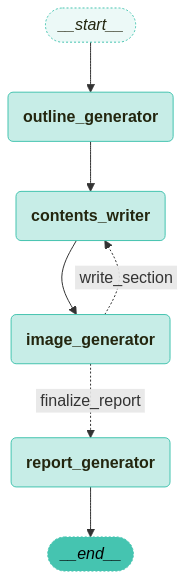

In [19]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph)

## 4. 실행

In [20]:
# 사용자 입력 받기
topic = input("보고서 주제를 입력하세요: ")
total_sections = int(input("생성할 섹션의 수를 입력하세요: "))

# 초기 상태 설정
initial_state = {
    "messages": [HumanMessage(content=topic)],
    "total_sections": total_sections,
    "current_section": 1,
}

# 그래프 실행
for chunk in graph.stream(initial_state,stream_mode="update"):
    print(chunk)

print("\n=== 보고서 생성 완료 ===")

Completed section 1 of 3
Completed section 2 of 3
Completed section 3 of 3

=== 보고서 생성 완료 ===


--------
** End of Documents **